In [5]:
nb_classes = 100                     # move to 1. step
model_filename = "eff100-gray.h5"


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import math
import numpy as np

def plot_dataset(images, labels, columns=12, rows=5, figsize=(18, 10)):

    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title(labels[i-1])  # set title
        if(images[i-1].shape[-1]==1):
            plt.imshow((images[i-1]), aspect='auto', cmap='gray')
        else:
            plt.imshow((images[i-1]), aspect='auto')
        plt.tight_layout()
    plt.show()

def plot_divergence(divergationset, title1, nb_classes):
    fig = plt.figure(figsize=(40, 10))
    fig.suptitle(title1)
    plt.bar(np.arange (0, nb_classes/10, 0.1), divergationset, width=0.09, align='center')
    plt.ylabel('count')
    plt.xlabel('digit class')
    plt.xticks(np.arange(0, nb_classes/10, 0.1))
    return fig



def class_encoding(y_train, nb_classes):
    ret = np.zeros((len(y_train), nb_classes))
    for i, y in enumerate(y_train):
        #print(i, y, int((y*10)))
        ret[i, int((y*10))] = 1
    return ret

def class_decoding(y_train, nb_classes=100):
    ret = np.zeros((len(y_train), 1))
    for i, y in enumerate(y_train):
        ret[i] = (np.argmax(y))/10
    return ret

In [7]:
import os
import shutil
from PIL import Image 

def ziffer_data_files(input_dir='images'):
    imgfiles = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if (file.endswith(".jpg") and not file.startswith("10_")):
                #print(root + "/" + file)
                imgfiles.append(root + "/" + file)
    return  imgfiles

def ziffer_data( use_grayscale=True):
    y_file = []
    y_data = []
    x_data = []
    files = ziffer_data_files("images")
    y_data = np.array(y_data).reshape(-1,1)
    y_file = np.array(y_file).reshape(-1,1)
    if (use_grayscale):
        x_data = np.array(x_data).reshape(-1,32,20,1)
    else: 
        x_data = np.array(x_data).reshape(-1,32,20,3)

    for aktfile in files:
        base = os.path.basename(aktfile)
        if (base[1]=="."):
            target = base[0:3]
        else:
            target = base[0:1]
        if target == "N":
            category = 10                # NaN does not work --> convert to 10

        else:
            category = float(target)
        test_image = Image.open(aktfile).resize((20, 32))
        if (use_grayscale):
            test_image = test_image.convert('L')
        test_image = np.array(test_image, dtype="float32")
        test_image = test_image/255.
            
        #print(test_image.shape)
        if (use_grayscale):
            test_image = test_image.reshape(1,32,20,1)
        else:
            test_image = test_image.reshape(1,32,20,3)

        # ignore the category 10
        if ( category<10):
            y_file = np.vstack((y_file, [base]))
            x_data = np.vstack((x_data, test_image))
            y_data = np.vstack((y_data, [category]))
    print("Ziffer data count: ", len(y_data))   
    return x_data, y_data, y_file

def move_to_failure_dir(filename, input_dirs=['images'], failure_dir='failures', ):
    for input_dir in input_dirs:
        for root, dirs, files in os.walk(input_dir):
            for file in files:
                if file.startswith(filename):
                    shutil.move(os.path.join(root, file), os.path.join(failure_dir,file))


Ziffer data count:  3122


2022-05-22 19:54:23.465896: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-22 19:54:23.557589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Tested images: 3122. 69 false predicted. Accuracy is: 0.9778987828315182


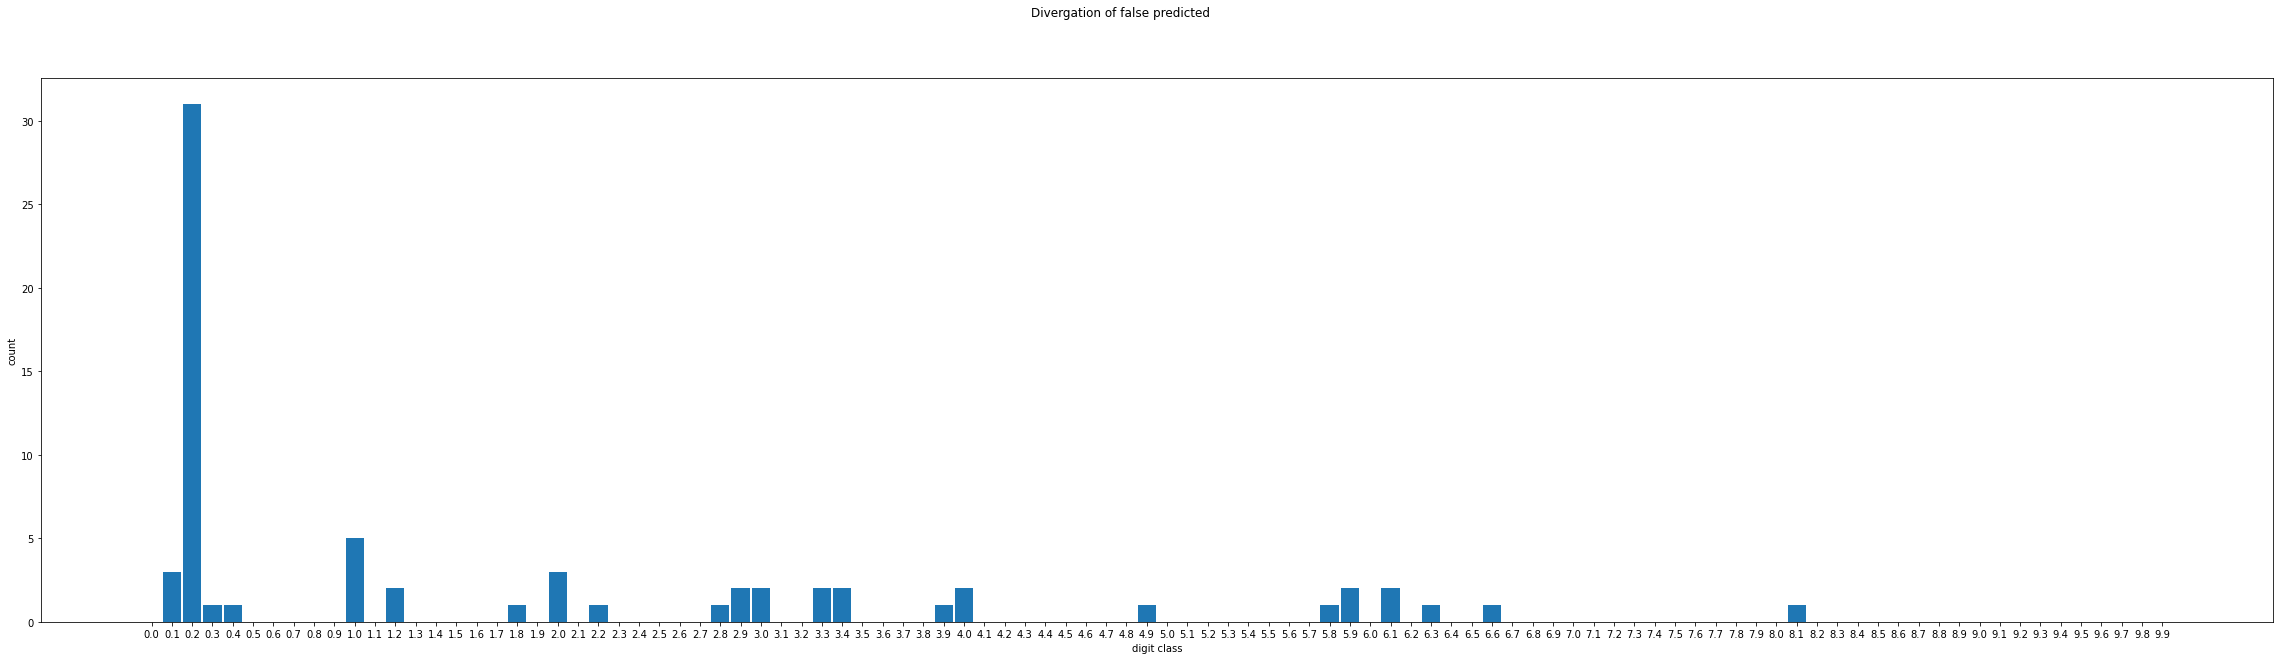

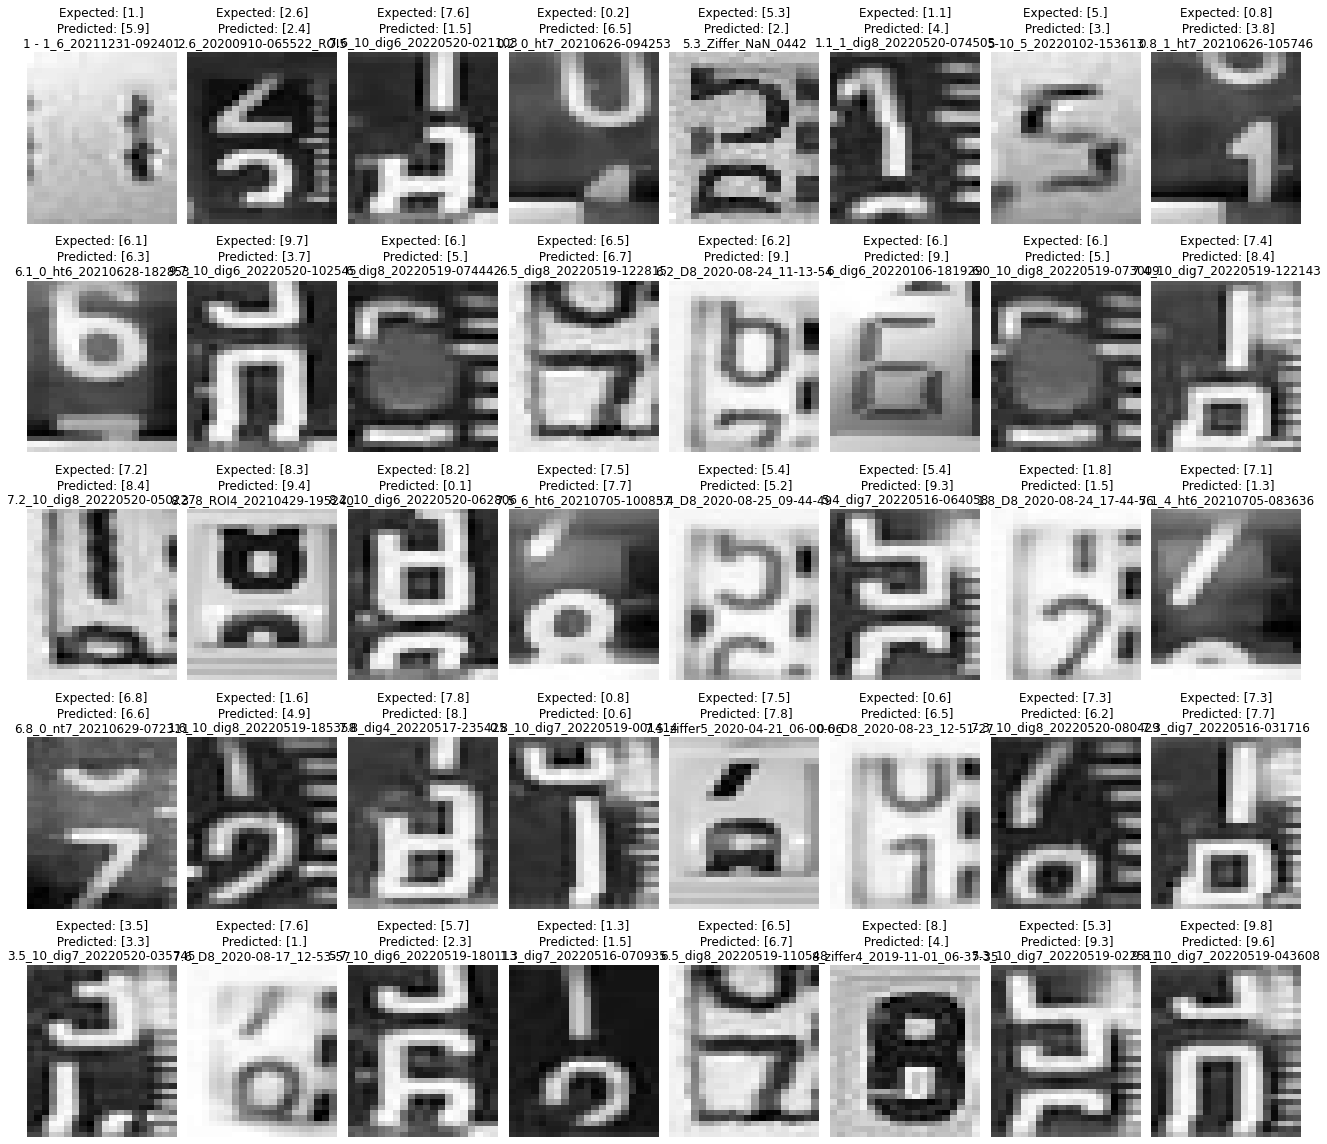

In [8]:
import numpy as np
import math
from operator import itemgetter
import tensorflow.keras as keras

res = []
stat_Abweichung = np.zeros(nb_classes)
false_img = []
false_label = []
max_delta = 0.11

model = keras.models.load_model(model_filename)

def isclose(a, b, delta):
    return min(abs(a-b),abs(a-(10-b)))<=delta

xz_data, yz_data, fz_data = ziffer_data(use_grayscale=True)
input_shape=xz_data[0].shape

for x, y, filename in zip(xz_data, yz_data, fz_data):

    target = y
    classes = model.predict(np.expand_dims(x.reshape(input_shape), axis=0))
    out_target = class_decoding(classes)[0]
    res.append(out_target)
                   
    if not isclose(target, out_target, max_delta) :
        lbl_text = "Expected: " + str(target) + "\n Predicted: " + str(out_target) + "\n" + filename[0][:-4]
        #print("Exp: " + str(target) + " Pred: " + str(out_target))
        false_img.append(x)
        false_label.append(lbl_text)
        stat_Abweichung[int(abs(target-out_target)*10)] = stat_Abweichung[int(abs(target-out_target)*10)]+1
        # move image to failure_dir 
        move_to_failure_dir(filename[0])

res = np.asarray(res)
res_step_1 = res
print(f"Tested images: {len(yz_data)}. {len(false_label)} false predicted. Accuracy is: {1-len(false_label)/len(yz_data)}")
plot_divergence(stat_Abweichung, "Divergation of false predicted", nb_classes)
#print(confusion_matrix(res, yz_data, nb_classes))
plot_dataset(np.array(false_img), false_label, columns=8, rows=5, figsize=(18,16))